## Download the relevant CMORPH data from website and store in a folder

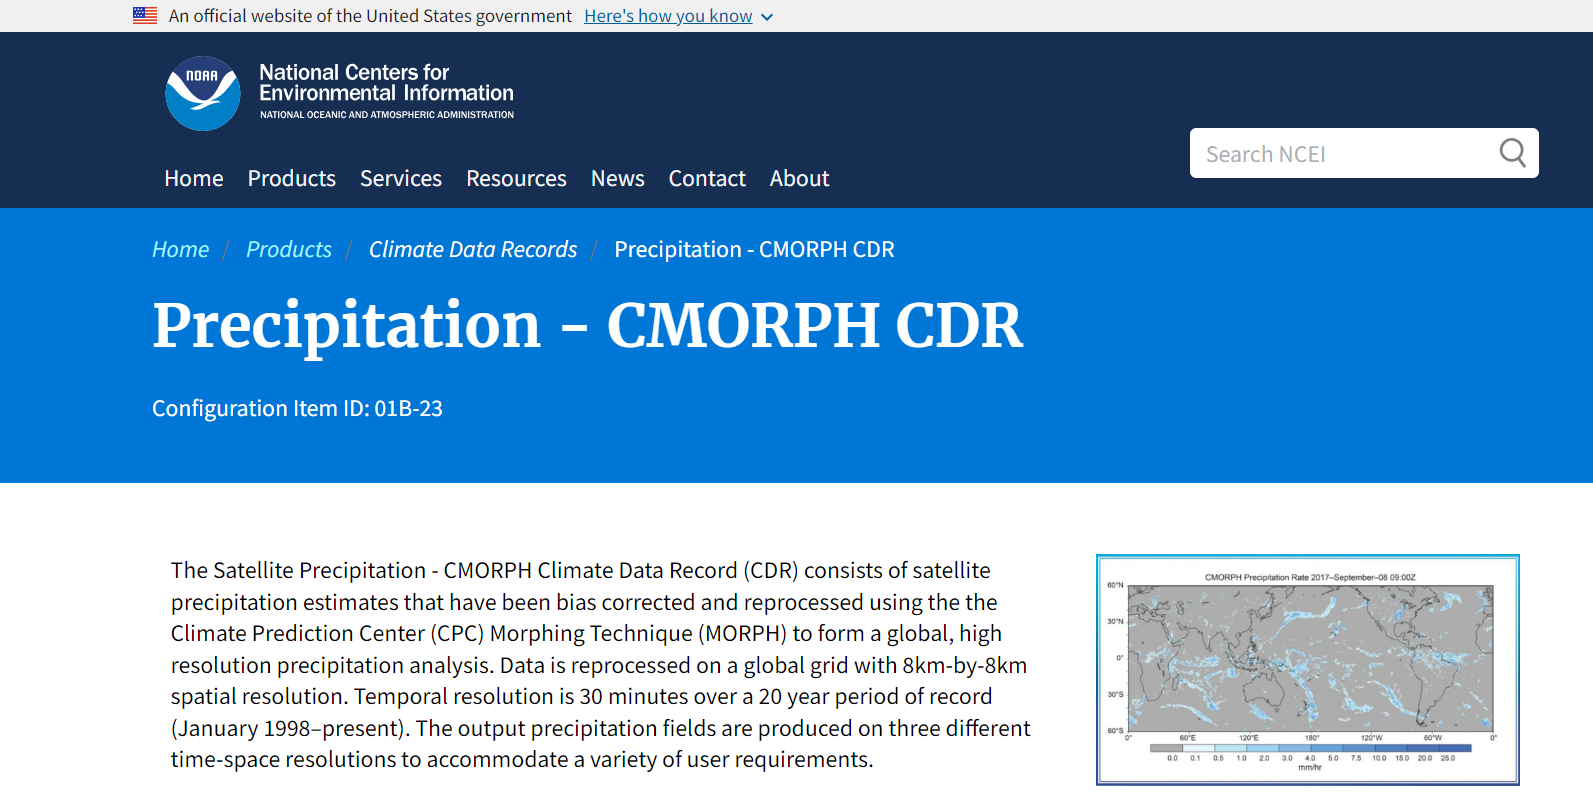

## Integrated code

The code shall run through all the files and extract the boundary box around Singapore to produce gridded precipitation in the D2 region. The user shall input the required start and end date as well as lat lon boundaries and the code will automatically download, extract and combine monthly.

Debug: There will be instances where due to connectivity or server request, the files fail to download and extract properly which may lead to improper merging. If so, comment out merging lines and run the next 2 code blocks

In [ ]:
import os
import requests
import xarray as xr
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import calendar
import shutil

def generate_urls(year, month):
    base_url = "https://www.ncei.noaa.gov/data/cmorph-high-resolution-global-precipitation-estimates/access/30min/8km/"
    urls = []
    last_day = calendar.monthrange(year, month)[1]
    start_date = datetime(year, month, 1)
    end_date = datetime(year, month, last_day, 23)  # Include the last hour of the last day

    current_date = start_date
    while current_date <= end_date:
        year_str = current_date.strftime("%Y")
        month_str = current_date.strftime("%m")
        day_str = current_date.strftime("%d")
        hour_str = current_date.strftime("%H")
        url = f"{base_url}{year_str}/{month_str}/{day_str}/CMORPH_V1.0_ADJ_8km-30min_{year_str}{month_str}{day_str}{hour_str}.nc"
        urls.append(url)
        current_date += timedelta(hours=1)
    
    return urls

def download_file(url, output_dir):
    local_filename = os.path.join(output_dir, url.split("/")[-1])
    try:
        with requests.get(url, stream=True, timeout=30) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        return local_filename, None
    except Exception as e:
        return url, e

def download_all_files(urls, output_dir, max_workers=10):
    os.makedirs(output_dir, exist_ok=True)
    results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {executor.submit(download_file, url, output_dir): url for url in urls}
        
        for future in tqdm(as_completed(future_to_url), total=len(urls), desc="Downloading files"):
            url = future_to_url[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Failed to download {url}: {e}")
    
    # Log any failed downloads
    failed_downloads = [result for result in results if result[1] is not None]
    if failed_downloads:
        with open('failed_downloads.log', 'a') as f:
            for url, error in failed_downloads:
                f.write(f"{url} - {error}\n")
        print(f"Some downloads failed. Check 'failed_downloads.log' for details.")
    else:
        print("All downloads completed successfully.")

    return [result[0] for result in results if result[1] is None]

def extract_all_areas(output_dir, extracted_dir, area_of_interest):
    os.makedirs(extracted_dir, exist_ok=True)
    extracted_files = []
    for file_name in tqdm(os.listdir(output_dir), desc="Extracting areas"):
        if file_name.endswith('.nc'):
            file_path = os.path.join(output_dir, file_name)
            try:
                ds = xr.open_dataset(file_path)
                lat_min, lon_min, lat_max, lon_max = area_of_interest
                extracted_data = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

                # Extract the timestamp from the filename
                time_str = file_name.split('_')[-1].split('.')[0]
                timestamp = datetime.strptime(time_str, "%Y%m%d%H")
                
                # Save the extracted data to a new NetCDF file with the desired format
                extracted_filename = os.path.join(extracted_dir, f"{timestamp.strftime('%Y%m%d%H')}.nc")
                try:
                    extracted_data.to_netcdf(extracted_filename)
                except PermissionError:
                    print(f"Permission denied when trying to save {extracted_filename}. Retrying in 5 seconds...")
                    time.sleep(3)
                    extracted_data.to_netcdf(extracted_filename)
                ds.close()
                # Optionally, remove the original file to save space
                os.remove(file_path)
                extracted_files.append(extracted_filename)
                
            except Exception as e:
                print(f"Failed to extract area from {file_path}: {e}")

    return extracted_files

def merge_files_to_nc(extracted_dir, merged_filename):
    try:
        nc_files = [os.path.join(extracted_dir, f) for f in os.listdir(extracted_dir) if f.endswith('.nc')]
        ds_list = [xr.open_dataset(f) for f in nc_files]
        combined_ds = xr.concat(ds_list, dim='time')
        combined_ds.to_netcdf(merged_filename)
        print(f"Successfully merged files into {merged_filename}")
    except Exception as e:
        print(f"Failed to merge files: {e}")

if __name__ == "__main__":
    start_year = 2020
    end_year = 2023
    start_month = 1
    end_month = 12
    output_dir = "raw_cmorph_data"  # Directory to save the downloaded files
    extracted_dir = "extracted_cmorph_data"  # Directory to save the extracted area files
    merged_dir = "merged_cmorph_data"  # Directory to save the merged files
    max_workers = 25  # Adjust the number of threads for concurrency

    # Define the area of interest (lat_min, lon_min, lat_max, lon_max)
    area_of_interest = (-7.29, 93.16, 9.972, 110.422)

    os.makedirs(merged_dir, exist_ok=True)

    # Process month by month
    for year in range(start_year, end_year + 1):
        for month in range(start_month, end_month + 1):
            print(f"Processing {year}-{month:02d}")

            # Generate URLs
            urls = generate_urls(year, month)

            # Download files
            downloaded_files = download_all_files(urls, output_dir, max_workers)

            # Create a monthly extracted directory
            monthly_extracted_dir = os.path.join(extracted_dir, f"{year}_{month:02d}")
            os.makedirs(monthly_extracted_dir, exist_ok=True)

            # Extract area of interest from downloaded files
            extracted_files = extract_all_areas(output_dir, monthly_extracted_dir, area_of_interest)
            
            '''
            # Commented out the merging step for now
            # Merge the extracted files into one NetCDF file per month
            #merged_filename = os.path.join(merged_dir, f"{year}_{month:02d}.nc")
            #merge_files_to_nc(monthly_extracted_dir, merged_filename)


            '''
            print(f"Completed processing for {year}-{month:02d}")

    print("All download and extraction processes completed.")


## Redownload

This code block below is to catch any missing files in the folder, log it and redownload

In [ ]:
import os
import requests
import xarray as xr
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import calendar

def generate_expected_files(year, month):
    base_url = "https://www.ncei.noaa.gov/data/cmorph-high-resolution-global-precipitation-estimates/access/30min/8km/"
    last_day = calendar.monthrange(year, month)[1]
    start_date = datetime(year, month, 1)
    end_date = datetime(year, month, last_day, 23)  # Include the last hour of the last day

    expected_files = []
    current_date = start_date
    while current_date <= end_date:
        year_str = current_date.strftime("%Y")
        month_str = current_date.strftime("%m")
        day_str = current_date.strftime("%d")
        hour_str = current_date.strftime("%H")
        filename = f"{year_str}{month_str}{day_str}{hour_str}.nc"
        url = f"{base_url}{year_str}/{month_str}/{day_str}/CMORPH_V1.0_ADJ_8km-30min_{year_str}{month_str}{day_str}{hour_str}.nc"
        expected_files.append((filename, url))
        current_date += timedelta(hours=1)
    
    return expected_files

def download_file(url, output_dir):
    local_filename = os.path.join(output_dir, url.split("/")[-1])
    try:
        with requests.get(url, stream=True, timeout=30) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        return local_filename, None
    except Exception as e:
        return url, e

def download_all_files(urls, output_dir, max_workers=10):
    os.makedirs(output_dir, exist_ok=True)
    results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {executor.submit(download_file, url, output_dir): url for url in urls}
        
        for future in tqdm(as_completed(future_to_url), total=len(urls), desc="Downloading files"):
            url = future_to_url[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Failed to download {url}: {e}")
    
    # Log any failed downloads
    failed_downloads = [result for result in results if result[1] is not None]
    if failed_downloads:
        with open('failed_downloads.log', 'a') as f:
            for url, error in failed_downloads:
                f.write(f"{url} - {error}\n")
        print(f"Some downloads failed. Check 'failed_downloads.log' for details.")
    else:
        print("All downloads completed successfully.")

    return [result[0] for result in results if result[1] is None]

def extract_area(file_path, extracted_dir, area_of_interest):
    os.makedirs(extracted_dir, exist_ok=True)
    try:
        ds = xr.open_dataset(file_path)
        lat_min, lon_min, lat_max, lon_max = area_of_interest
        extracted_data = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

        # Extract the timestamp from the filename
        time_str = file_path.split('_')[-1].split('.')[0]
        timestamp = datetime.strptime(time_str, "%Y%m%d%H")
        
        # Save the extracted data to a new NetCDF file with the desired format
        extracted_filename = os.path.join(extracted_dir, f"{timestamp.strftime('%Y%m%d%H')}.nc")
        extracted_data.to_netcdf(extracted_filename)
        ds.close()
        
        # Optionally, remove the original file to save space
        os.remove(file_path)
        return extracted_filename
        
    except Exception as e:
        print(f"Failed to extract area from {file_path}: {e}")
        return None

def check_and_download_missing_files(base_dir, output_dir, extracted_dir, area_of_interest, max_workers=10):
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            year, month = map(int, folder_name.split('_'))
            files_in_folder = [f for f in os.listdir(folder_path) if f.endswith('.nc')]
            num_files = len(files_in_folder)
            
            if num_files % 24 != 0:
                print(f"Folder {folder_name} has {num_files} files, which is not a multiple of 24.")
                
                # Generate expected files list
                expected_files = generate_expected_files(year, month)
                
                # Find missing files
                missing_files = set([filename for filename, url in expected_files]) - set(files_in_folder)
                missing_urls = [url for filename, url in expected_files if filename in missing_files]

                if missing_urls:
                    print(f"Missing files for {year}-{month:02d}: {len(missing_urls)}")
                    # Download missing files
                    downloaded_files = download_all_files(missing_urls, output_dir, max_workers)
                    
                    # Extract area of interest from downloaded files
                    for file_path in downloaded_files:
                        extract_area(file_path, folder_path, area_of_interest)

if __name__ == "__main__":
    base_dir = r"C:\Users\userAdmin\Desktop\Climate Database\extracted_cmorph_data"  # Base directory
    output_dir = "raw_cmorph_data"  # Directory to save the downloaded files
    extracted_dir = "extracted_cmorph_data"  # Directory to save the extracted area files
    max_workers = 25

    # Define the area of interest (lat_min, lon_min, lat_max, lon_max)
    area_of_interest = (-7.29, 93.16, 9.972, 110.422)
    os.makedirs(output_dir, exist_ok=True)
    check_and_download_missing_files(base_dir, output_dir, extracted_dir, area_of_interest, max_workers)
    print("All download and extraction processes completed.")


## Remerge
This code block is to merge all the extracted files together by month AFTER we have redownloaded all missing files

In [ ]:
import os
import xarray as xr
from tqdm import tqdm

def merge_files_to_nc(folder_path, merged_filename):
    try:

        nc_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]
        ds_list = [xr.open_dataset(f) for f in nc_files]
        combined_ds = xr.concat(ds_list, dim='time')
        combined_ds.to_netcdf(merged_filename)
        print(f"Successfully merged files into {merged_filename}")
    except Exception as e:
        print(f"Failed to merge files in {folder_path}: {e}")

if __name__ == "__main__":
    extracted_base_dir = r"C:\Users\userAdmin\Desktop\Climate Database\extracted_cmorph_data"  # Base directory with extracted files
    merged_base_dir = r"C:\Users\userAdmin\Desktop\Climate Database\merged_cmorph"  # Directory to save the merged files
    os.makedirs(merged_base_dir, exist_ok=True)

    # Process each folder in the extracted base directory
    for folder_name in os.listdir(extracted_base_dir):
        print(f"Processing {folder_name}")
        folder_path = os.path.join(extracted_base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            merged_filename = os.path.join(merged_base_dir, f"{folder_name}.nc")
            merge_files_to_nc(folder_path, merged_filename)
    
    print("All merging processes completed.")


## Point extraction

This code block finds the grid that contains the location of interest across the entire time frame and stores into a CSV file for quick comparison with other datasets

In [ ]:
import os
import pandas as pd
import xarray as xr

# Define the coordinates of interest
coordinates_of_interest = [
    {'name': 'Tengah', 'latitude': 1.386, 'longitude': 103.71},
    {'name': 'Changi', 'latitude': 1.387, 'longitude': 103.84},
    {'name': 'Choa Chu Kang', 'latitude': 1.385, 'longitude': 103.75}
]

merged_dir = r"C:\Users\userAdmin\Desktop\Climate Database\merged_cmorph"
data_dict = {
    'Datetime': [],
    'Tengah': [],
    'Changi': [],
    'Choa Chu Kang': []
}

# Process each merged file in the directory
for file_name in os.listdir(merged_dir):
    print(f"Processing {file_name}")
    if file_name.endswith('.nc'):
        file_path = os.path.join(merged_dir, file_name)
        ds = xr.open_dataset(file_path)
        time_series = pd.to_datetime(ds.time.values)

        for coord in coordinates_of_interest:
            lat = coord['latitude']
            lon = coord['longitude']
            name = coord['name']
            data = ds.sel(lat=lat, lon=lon, method='nearest')
            values = data['cmorph'].values # <--- Variable name
            
            if len(data_dict['Datetime']) < len(data_dict[name]) + len(time_series):
                data_dict['Datetime'].extend(time_series)
            data_dict[name].extend(values)

        ds.close()

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data_dict)
df.dropna(inplace=True)
df.to_csv('extracted_data_cmorph.csv', index=False)

print("Data extraction and saving to CSV completed.")


Plotting of netCDF4 data for quick visualisation

1488


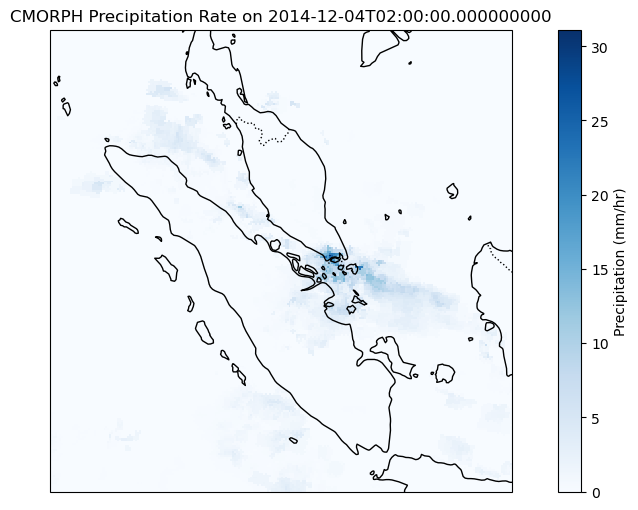

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
file_path = r"c:\Users\userAdmin\Desktop\Climate Database\CMORPH\merged_cmorph\2014_12.nc" ## <-- Change this to the path of your merged NetCDF file
ds = xr.open_dataset(file_path)
precipi = ds['cmorph']
print(len(ds["time"]))
# Plotting the data
fig = plt.figure(figsize=(12, 6))

# Define the projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the precipitation data for a specific time slice
time_slice = precipi.isel(time=148)  # Change the index to select a different time step
time_slice.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Precipitation (mm/hr)'})

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# Set the extent to focus on the area of interest
ax.set_extent([93.16, 110.42, -7.29, 9.972], crs=ccrs.PlateCarree())

# Add a title
plt.title(f'CMORPH Precipitation Rate on {time_slice["time"].values}')

# Show the plot
plt.show()
